# Step-1: Installation

In [1]:
!pip install -Uqq fastai
!pip install -Uqq utils
!pip install -Uqq fastai duckduckgo_search

# Step-2: Data Collection

### 2.1 Search Images Function

In [11]:
search_images_ddg

<function __main__.search_images_ddg(term, max_images=90)>

### 2.2 Downloading the images 

#### 2.2.1 F1 Ferrari

In [22]:
urls = search_images('F1 Ferrari', max_images=3)
urls[0]

Searching for 'F1 Ferrari'


'https://i0.wp.com/www.motoringresearch.com/wp-content/uploads/2018/12/TAMH-9650.jpg?resize=1500%2C844&ssl=1'

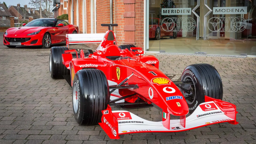

In [19]:
from fastdownload import download_url
dest = 'F1 Ferrari.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

#### 2.2.2 Ferrari Roma

Searching for 'Ferrari Roma photos'


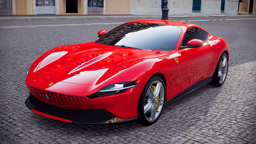

In [20]:
download_url(search_images('Ferrari Roma photos', max_images=1)[0], 'Ferrari Roma.jpg', show_progress=False)
Image.open('Ferrari Roma.jpg').to_thumb(256,256)

#### 2.2.3 Ferrari Monza SP1

Searching for 'Ferrari Monza SP1 photos'


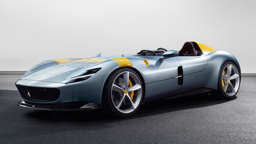

In [21]:
download_url(search_images('Ferrari Monza SP1 photos', max_images=1)[0], 'Ferrari Monza SP1.jpg', show_progress=False)
Image.open('Ferrari Monza SP1.jpg').to_thumb(256,256)

### 2.3 Storing the Images

In [23]:
searches = 'F1 Ferrari','Ferrari Roma','Ferrari Monza SP1'
path = Path('Ferrari')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True) 
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server

    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'F1 Ferrari photo'
Searching for 'Ferrari Roma photo'
Searching for 'Ferrari Monza SP1 photo'


# Step-3: Train the model

### 3.1 For the perfect Images

In [30]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

### 3.2 The Dataloader

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


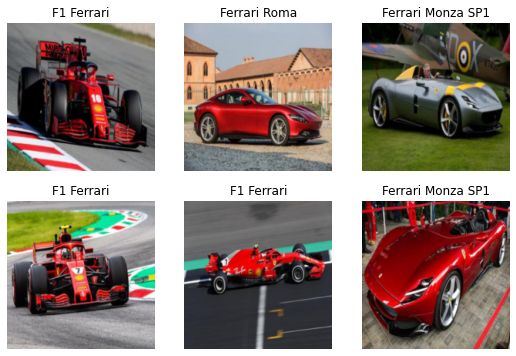

In [31]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), # datablock parameters
    get_items=get_image_files,#The inputs to our model are images, and the outputs are categories 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),#To find all the inputs to our model, run the get_image_files function 
    get_y=parent_label,#Split the data into training and validation sets randomly, using 20% of the data for the validation set.
    item_tfms=[Resize(192, method='squish')]#The labels (y values) is the name of the parent of each file
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

### 3.3 Training

In [32]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

F:\Anaconda\File for Ana\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
F:\Anaconda\File for Ana\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.755003,0.715891,0.282609,00:09


epoch,train_loss,valid_loss,error_rate,time
0,0.578505,0.429978,0.173913,00:11
1,0.468485,0.327828,0.108696,00:10
2,0.325946,0.220211,0.086957,00:11
3,0.253344,0.155823,0.065217,00:11
4,0.200912,0.136645,0.065217,00:10
5,0.160354,0.143045,0.065217,00:10
6,0.130931,0.144365,0.086957,00:10
7,0.108966,0.136995,0.086957,00:10
8,0.093227,0.140892,0.065217,00:10
9,0.079839,0.134187,0.065217,00:10


# Step-4: Build a Model

In [33]:
is_F1_Ferrari,_,probs = learn.predict(PILImage.create('F1 Ferrari.jpg'))
print(f"This is a: {is_F1_Ferrari}.")
print(f"Probabilities-")
for i in range(len(searches)):
    print(f'{searches[i]}:    {(probs[i]*100):.4f}%' )

This is a: F1 Ferrari.
Probabilities-
F1 Ferrari:    99.9953%
Ferrari Roma:    0.0002%
Ferrari Monza SP1:    0.0045%


### 4.1 Create a confusion matrix

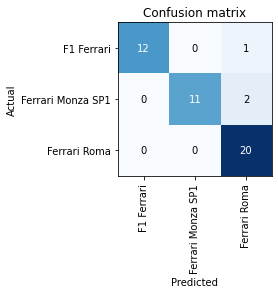

In [34]:
#we use confusion matrix for a more detailed analysis than simply observing the proportion of correct classifications
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [35]:
learn.export("Ferrari.pkl")#When we call export, fastai will save a file called "export.pkl"

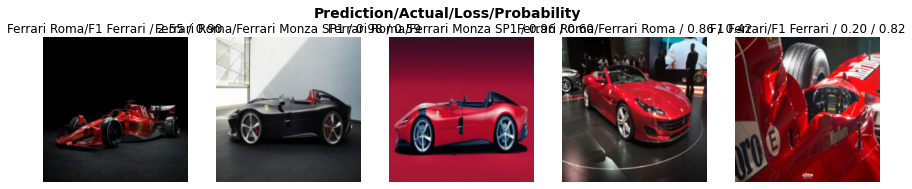

In [37]:
interp.plot_top_losses(5, nrows=1)